In [1]:
import pandas as pd
from ptrail.core.TrajectoryDF import PTRAILDataFrame
from ptrail.preprocessing.statistics import Statistics

"""
    First, to begin with the following actions ar performed:
        1. Read the database from the csv file using pandas.
        2. Convert the pandas dataframe to PTRAILDataFrame DataFrame
           in order to represent the data with PTRAIL.

    It is to be duly noted that the Starkey Project database provided
    originally has been modified here to meet with the needs of
    PTRAIL Library.
"""
pdf = pd.read_csv('https://raw.githubusercontent.com/YakshHaranwala/PTRAIL/main/examples/data/starkey.csv')
starkey = PTRAILDataFrame(data_set=pdf,
                          latitude='lat',
                          longitude='lon',
                          datetime='DateTime',
                          traj_id='Id')
print("Size of the Dataset: {}".format(starkey.shape))
starkey.head(5)

Size of the Dataset: (287136, 15)


lat         lon  StarkeyTime    GMDate  \
traj_id   DateTime                                                            
880109D01 1995-04-13 13:40:06  45.239682 -118.533204    229902006  21:40:06   
          1995-04-15 12:16:15  45.250521 -118.530438    230069775  20:16:15   
          1995-04-15 21:39:38  45.247943 -118.541455    230103578  05:39:38   
          1995-04-16 03:32:14  45.247429 -118.539530    230124734  11:32:14   
          1995-04-16 04:08:28  45.247117 -118.542579    230126908  12:08:28   

                                 GMTime   LocDate   LocTime  RadNum  Species  \
traj_id   DateTime                                                             
880109D01 1995-04-13 13:40:06  19950413  19950413  13:40:06     409        0   
          1995-04-15 12:16:15  19950415  19950415  12:16:15     409        0   
          1995-04-15 21:39:38  19950416  19950415  21:39:38     409        0   
          1995-04-16 03:32:14  19950416  19950416  03:32:14     409        0   
          1995-04-16 04:08:28  19950416  19950416  04:08:28     409        0   

                                 UTME     UTMN  Year  Grensunr  Grensuns  \
traj_id   DateTime                                                         
880109D01 1995-04-13 13:40:06  379662  5010734    95  13:13:00  02:39:00   
          1995-04-15 12:16:15  379895  5011927    95  13:09:00  02:41:00   
          1995-04-15 21:39:38  379039  5011656    95  13:07:00  02:43:00   
          1995-04-16 03:32:14  379188  5011581    95  13:07:00  02:43:00   
          1995-04-16 04:08:28  378938  5011567    95  13:07:00  02:43:00   

                               Obswt  
traj_id   DateTime                    
880109D01 1995-04-13 13:40:06   1.47  
          1995-04-15 12:16:15   1.59  
          1995-04-15 21:39:38   1.34  
          1995-04-16 03:32:14   1.50  
          1995-04-16 04:08:28   1.34

In [2]:
"""
Our course of action

1. First, generate a set of spatial and temporal features on the
   dataset.
2. Then, based on the above generated features, clean the dataset
   to reduce noise as well as make the trajectories smoother.
3. Then, once the noise has been cleared, we will further make
   the trajectory smoother, we will interpolate the trajectories.
   Now, an important point to consider for interpolation is that
   only 4 fundamental columns are returned.
4. Then, train various models based on the original starkey dataset.
5. Based on that trained model, we will predict the species of the
   animal for the interpolated and cleaned dataset.
"""

'\nOur course of action\n\n1. First, generate a set of spatial and temporal features on the\n   dataset.\n2. Then, based on the above generated features, clean the dataset\n   to reduce noise as well as make the trajectories smoother.\n3. Then, once the noise has been cleared, we will further make\n   the trajectory smoother, we will interpolate the trajectories.\n   Now, an important point to consider for interpolation is that\n   only 4 fundamental columns are returned.\n4. Then, train various models based on the original starkey dataset.\n5. Based on that trained model, we will predict the species of the\n   animal for the interpolated and cleaned dataset.\n'

In [3]:
%%time

# Step - 1: Feature generation.
# The following features are being generated:
#   1. Distance between consecutive points of the trajectory.
from ptrail.features.kinematic_features import KinematicFeatures
from ptrail.features.temporal_features import TemporalFeatures

starkey_feat = KinematicFeatures.create_distance_column(starkey)
starkey_feat = TemporalFeatures.create_time_of_day_column(starkey_feat)

CPU times: user 1.25 s, sys: 248 ms, total: 1.5 s
Wall time: 1.76 s


In [4]:
%%time

# Step - 2: Filtering.

# 2.1: Hampel filter based on distance between consecutive points.
from ptrail.preprocessing.filters import Filters

hamp_filt_starkey = Filters.hampel_outlier_detection(dataframe=starkey_feat,
                                                     column_name='Distance')
print(f"Length of original Dataframe: {len(starkey_feat)}")
print(f"Length of DataFrame after filtering: {len(hamp_filt_starkey)}")

/home/shaidri/Desktop/PT/ptrail/preprocessing/filters.py:726: UserWarning: If kinematic features have been generated on the dataframe, then make sure to generate them again as outlier detection drops the point from the dataframe and does not run the kinematic features again.
  warnings.warn("If kinematic features have been generated on the dataframe, then make "


Length of original Dataframe: 287136
Length of DataFrame after filtering: 262207
CPU times: user 699 ms, sys: 226 ms, total: 925 ms
Wall time: 15.1 s


In [5]:
# 2.2: Remove duplicate points from the trajectories.

dupl_filt_starkey = Filters.remove_duplicates(dataframe=hamp_filt_starkey)
dupl_filt_starkey = dupl_filt_starkey.drop_duplicates(subset=['DateTime', 'traj_id'])
print(f"Length of original Dataframe: {len(hamp_filt_starkey)}")
print(f"Length of DataFrame after filtering: {len(dupl_filt_starkey)}")

Length of original Dataframe: 262207
Length of DataFrame after filtering: 262206


In [6]:
# 2.3 Remove trajectories with few points.

few_filt_starkey = Filters.remove_trajectories_with_less_points(dataframe=dupl_filt_starkey,
                                                                num_min_points=5)
print(f"Length of original Dataframe: {len(dupl_filt_starkey)}")
print(f"Length of DataFrame after filtering: {len(few_filt_starkey)}")

Length of original Dataframe: 262206
Length of DataFrame after filtering: 262206


In [7]:
# Now, we generate kinematic statistics on the DF and then change the
# representation of the Trajectory to be segment based instead of point based.

stats_df = Statistics.generate_kinematic_stats(dataframe=few_filt_starkey,
                                               target_col_name='Species')
pivoted = Statistics.pivot_stats_df(dataframe=stats_df,
                                    target_col_name='Species')
pivoted

,10%_Distance,25%_Distance,50%_Distance,75%_Distance,90%_Distance,min_Distance,max_Distance,mean_Distance,std_Distance,10%_Distance_from_start,...,10%_Rate_of_bearing_rate,25%_Rate_of_bearing_rate,50%_Rate_of_bearing_rate,75%_Rate_of_bearing_rate,90%_Rate_of_bearing_rate,min_Rate_of_bearing_rate,max_Rate_of_bearing_rate,mean_Rate_of_bearing_rate,std_Rate_of_bearing_rate,Species
traj_id,,,,,,,,,,,,,,,,,,,,,
910313E37,30.022296,66.956698,134.181480,284.731786,601.445028,0.000000,6205.384711,266.132622,418.058817,1129.445835,...,-0.061602,-0.025216,5.642640e-08,0.024152,0.063510,-6.036678,2.449554,-0.001423,0.151256,1
890424E08,42.384555,84.780094,174.620248,365.204845,739.670455,0.000000,7466.153243,321.929717,464.688410,665.186319,...,-0.061199,-0.022772,1.174658e-07,0.021624,0.061871,-11.536372,1.022737,-0.008423,0.255552,1
921228E06,42.390004,90.066708,200.847653,424.559571,878.857805,0.000000,5627.670877,369.912854,509.015446,807.858525,...,-0.053586,-0.018901,-6.826990e-05,0.017404,0.052331,-56.020652,4.466711,-0.017891,1.049811,1
930304E16,42.384004,67.090133,152.597896,334.571444,684.682660,0.000000,5977.173040,292.121524,421.497409,1183.322279,...,-0.063274,-0.024253,1.731773e-05,0.025564,0.061628,-7.865121,30.406105,0.003907,0.610773,1
940110D01,30.022174,66.956679,149.612247,282.568230,491.721929,0.000000,1969.437420,217.759366,228.728350,491.768051,...,-0.039799,-0.017002,0.000000e+00,0.017616,0.041103,-5.547235,200.192244,0.079246,3.815192,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OSUX92071,42.384803,111.029114,276.330340,509.415791,1222.690175,0.000000,4968.850596,524.650689,774.791130,2265.998957,...,-0.011482,-0.005646,1.318267e-04,0.005145,0.017379,-0.180602,0.032870,-0.000672,0.022412,2
OSUX92008,60.044073,119.689963,335.628622,617.200624,931.170539,0.000000,4186.713715,483.921182,666.970217,2318.326105,...,-0.025204,-0.005223,2.234344e-04,0.006801,0.021601,-0.119311,0.119162,-0.001099,0.032279,2
OSUX91143,91.899800,149.800099,299.879846,659.816699,1483.970205,42.389900,6594.400615,693.025123,1143.737915,2746.440810,...,-0.010185,-0.002630,1.764249e-04,0.005429,0.011010,-0.029209,0.034114,0.001737,0.011468,2


In [8]:
# Step-5: Getting the test and train datasets ready.
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


X_train, X_test, y_train, y_test = train_test_split(pivoted.drop(columns=['Species']), pivoted['Species'],
                                                    random_state=7, test_size=0.2)

In [9]:
# Now it is time to train some models and predict
# the ship types.

# 1. RandomForestClassifier model.
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Now, lets predict on the training and testing set
# using the above trained model.
rf_train_predict = rf_model.predict(X_train)
rf_test_predict = rf_model.predict(X_test)


# Finally, lets test the accuracy of the model on both
# the datasets.
rf_train_accuracy = f1_score(y_train, rf_train_predict, average='weighted')
rf_test_accuracy = f1_score(y_test, rf_test_predict, average='weighted')

print('---------------- RandomForest Classifier -----------------')
print(f"The f1_score of RF training is: {round(rf_train_accuracy*100, 2)}%")
print(f"The f1_score of RF testing is: {round(rf_test_accuracy*100, 2)}%")
print('----------------------------------------------------------\n')

# ----------------------------------------------------------------------------------- #

# 2. DecisionTree Classifier model.
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

# Now, lets predict on the training and testing set
# using the above trained model.
dt_train_predict = dt_model.predict(X_train)
dt_test_predict = dt_model.predict(X_test)


# Finally, lets test the accuracy of the model on both
# the datasets.
dt_train_accuracy = f1_score(y_train, dt_train_predict, average='weighted')
dt_test_accuracy = f1_score(y_test, dt_test_predict, average='weighted')

print('---------------- DecisionTree Classifier -----------------')
print(f"The f1_score of DT training is: {round(dt_train_accuracy*100, 2)}%")
print(f"The f1_score of DT testing is: {round(dt_test_accuracy*100, 2)}%")
print('----------------------------------------------------------\n')

# ----------------------------------------------------------------------------------- #

# 3. Gaussian Naive Bayes model.
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)

# Now, lets predict on the training and testing set
# using the above trained model.
gnb_train_predict = gnb_model.predict(X_train)
gnb_test_predict = gnb_model.predict(X_test)


# Finally, lets test the accuracy of the model on both
# the datasets.
gnb_train_accuracy = f1_score(y_train, gnb_train_predict, average='weighted')
gnb_test_accuracy = f1_score(y_test, gnb_test_predict, average='weighted')

print('----------------- Naive Bayes Classifier -----------------')
print(f"The f1_score of GNB training is: {round(gnb_train_accuracy*100, 2)}%")
print(f"The f1_score of GNB testing is: {round(gnb_test_accuracy*100, 2)}%")
print('----------------------------------------------------------\n')

# ----------------------------------------------------------------------------------- #

# 4. K-Nearest Neighbors Classifier model.

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

# Now, lets predict on the training and testing set
# using the above trained model.
knn_train_predict = knn_model.predict(X_train)
knn_test_predict = knn_model.predict(X_test)


# Finally, lets test the accuracy of the model on both
# the datasets.
knn_train_accuracy = f1_score(y_train, knn_train_predict, average='weighted')
knn_test_accuracy = f1_score(y_test, knn_test_predict, average='weighted')

print('--------------------- KNN Classifier ---------------------')
print(f"The f1_score of KNN training is: {round(knn_train_accuracy*100, 2)}%")
print(f"The f1_score of KNN testing is: {round(knn_test_accuracy*100, 2)}%")
print('----------------------------------------------------------\n')

---------------- RandomForest Classifier -----------------
The f1_score of RF training is: 100.0%
The f1_score of RF testing is: 84.68%
----------------------------------------------------------

---------------- DecisionTree Classifier -----------------
The f1_score of DT training is: 100.0%
The f1_score of DT testing is: 76.8%
----------------------------------------------------------

----------------- Naive Bayes Classifier -----------------
The f1_score of GNB training is: 71.47%
The f1_score of GNB testing is: 51.69%
----------------------------------------------------------

--------------------- KNN Classifier ---------------------
The f1_score of KNN training is: 81.55%
The f1_score of KNN testing is: 63.97%
----------------------------------------------------------



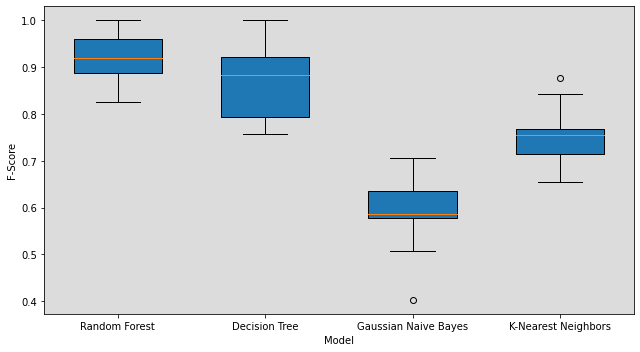

In [10]:
# Let's visualize the scores using box plot of cross validation of the models.
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold

names = ["Random Forest", "Decision Tree", "Gaussian Naive Bayes", "K-Nearest Neighbors"]
models = [RandomForestClassifier(), DecisionTreeClassifier(), GaussianNB(), KNeighborsClassifier()]

fig = plt.figure(figsize=(9, 5))
ax = plt.subplot(111)
ax.set_facecolor('gainsboro')

skf = StratifiedKFold(n_splits=10, random_state=10, shuffle=True)
for i, name, model in zip(range(0, 5), names, models):
    scores = cross_val_score(model, pivoted.drop(columns=['Species']), pivoted['Species'],
                             scoring='f1_weighted', cv=skf, n_jobs=-1)
    ax.boxplot(x=scores, positions=[i], vert=True,
               widths=0.60, patch_artist=True)

ax.set_xticklabels(labels=names)
ax.set_ylabel("F-Score")
ax.set_xlabel("Model")
plt.tight_layout()